In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from collections import defaultdict

from model import ReachabilityModel
from playclass import play

#### Create Array of Pandas Dataframes for each CSV File in Dataset

In [3]:
dfs = []
datapath = os.getcwd() + '\data'
for item in os.listdir(datapath):
    fullpath = os.path.join(datapath, item)
    if os.path.isfile(fullpath):
        dfs.append(pd.read_csv('data/' + item))

C:\Users\cwphu\AppData\Local\Temp\ipykernel_24464\3426312423.py:6: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv('data/' + item))


#### Clean Each Input/Output DF

In [4]:
def cleanInputData(df):
    cleandf = df.copy()
    # generate unique play id by concatenating game id (game), play id (play)
    cleandf['unique_play_id'] = cleandf['game_id'].astype(str) + cleandf['play_id'].astype(str)
    # generate x/y components of velocity, acceleration
    cleandf['v_x'] = np.sin(cleandf['dir']*2*np.pi/360.0) * cleandf['s']
    cleandf['v_y'] = np.cos(cleandf['dir']*2*np.pi/360.0) * cleandf['s']
    cleandf['a_x'] = np.sin(cleandf['dir']*2*np.pi/360.0) * cleandf['a']
    cleandf['a_y'] = np.cos(cleandf['dir']*2*np.pi/360.0) * cleandf['a']
    cleandf['o'] = cleandf['o']/360.0
    cleandf = cleandf.drop(columns=['s', 'a', 'dir'])
    return cleandf

def cleanOutputData(df):
    cleandf = df.copy()
    cleandf['unique_play_id'] = cleandf['game_id'].astype(str) + cleandf['play_id'].astype(str)
    return cleandf

def cleanSupplementaryData(df):
    cleandf = df.copy()
    cleandf['unique_play_id'] = cleandf['game_id'].astype(str) + cleandf['play_id'].astype(str)
    return cleandf

In [5]:
clean_input_dfs = []
for i in range(0, 18):
    clean_input_dfs.append(cleanInputData(dfs[i]))
clean_output_dfs = []
for i in range(18, 36):
    clean_output_dfs.append(cleanOutputData(dfs[i]))

clean_sup_df = cleanSupplementaryData(dfs[36])

In [6]:
clean_sup_df

,game_id,season,week,game_date,game_time_eastern,home_team_abbr,visitor_team_abbr,play_id,play_description,quarter,...,penalty_yards,pre_penalty_yards_gained,yards_gained,expected_points,expected_points_added,pre_snap_home_team_win_probability,pre_snap_visitor_team_win_probability,home_team_win_probability_added,visitor_team_win_probility_added,unique_play_id
0,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,3461,(10:46) (Shotgun) J.Goff pass deep left to J.R...,4,...,NaN,18,18,-0.664416,2.945847,0.834296,0.165704,-0.081149,0.081149,20230907003461
1,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,461,(7:30) J.Goff pass short right to J.Reynolds t...,1,...,NaN,21,21,1.926131,1.345633,0.544618,0.455382,-0.029415,0.029415,2023090700461
2,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,1940,(:09) (Shotgun) J.Goff pass incomplete deep ri...,2,...,NaN,0,0,0.281891,-0.081964,0.771994,0.228006,0.000791,-0.000791,20230907001940
3,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,1711,"(:45) (No Huddle, Shotgun) P.Mahomes pass deep...",2,...,NaN,26,26,3.452352,2.342947,0.663187,0.336813,0.041843,-0.041843,20230907001711
4,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,1588,(1:54) (Shotgun) P.Mahomes pass incomplete dee...,2,...,NaN,0,0,1.921525,-0.324035,0.615035,0.384965,0.000061,-0.000061,20230907001588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18004,2025010515,2024,18,01/05/2025,13:00:00,TEN,HOU,2090,"(:24) (No Huddle, Shotgun) D.Mills pass incomp...",2,...,NaN,0,0,5.091998,-0.527686,0.117869,0.882131,0.009368,-0.009368,20250105152090
18005,2025010515,2024,18,01/05/2025,13:00:00,TEN,HOU,3711,(5:41) (Shotgun) W.Levis pass short middle to ...,4,...,NaN,15,15,0.244685,0.853195,0.008630,0.991370,0.001104,-0.001104,20250105153711
18006,2025010515,2024,18,01/05/2025,13:00:00,TEN,HOU,2813,(1:25) (Shotgun) D.Mills pass incomplete short...,3,...,NaN,0,0,5.900082,-0.980367,0.086180,0.913820,-0.000479,0.000479,20250105152813
18007,2025010515,2024,18,01/05/2025,13:00:00,TEN,HOU,704,(2:32) (Shotgun) D.Mills pass short right to D...,1,...,NaN,10,10,-0.452001,-0.030521,0.334241,0.665759,0.000583,-0.000583,2025010515704


#### Generate Player ID -> Name Dictionary

In [7]:
player_dict = dict()
max_play_len = 0
for clean_dfs in clean_input_dfs:
    for _,row in clean_dfs.iterrows():
        id = row['nfl_id']
        max_play_len = max(max_play_len, row['frame_id'])
        if id not in player_dict:
            name = row['player_name']
            player_dict[id] = name

In [8]:
player_dict

{54527: 'Bryan Cook',
 46137: 'Justin Reid',
 52546: "L'Jarius Sneed",
 53487: 'Nick Bolton',
 54486: 'Trent McDuffie',
 53541: 'Amon-Ra St. Brown',
 53959: 'Brock Wright',
 43290: 'Jared Goff',
 44930: 'Josh Reynolds',
 44888: 'Alex Anzalone',
 55910: 'Brian Branch',
 47888: 'C.J. Gardner-Johnson',
 44906: 'Cameron Sutton',
 53953: 'Jerry Jacobs',
 54562: 'Kerby Joseph',
 54653: 'Malcolm Rodriguez',
 46213: 'Justin Watson',
 46243: 'Marquez Valdes-Scantling',
 53591: 'Noah Gray',
 54519: 'Skyy Moore',
 44822: 'Patrick Mahomes',
 41325: 'Jerick McKinnon',
 53542: 'Derrick Barnes',
 52440: 'Clyde Edwards-Helaire',
 46309: 'Richie James',
 54495: 'George Karlaftis',
 47882: 'Mike Edwards',
 43584: 'Kalif Raymond',
 55899: 'Sam LaPorta',
 38696: 'Marvin Jones',
 54600: 'Joshua Williams',
 55984: 'Chamarri Conner',
 52471: 'Willie Gay Jr.',
 47856: 'David Montgomery',
 55876: 'Jahmyr Gibbs',
 54568: 'Leo Chenal',
 46424: 'Jason Cabinda',
 55882: 'Jack Campbell',
 54716: 'Isiah Pacheco',
 5

#### Process Input Datasets

In [9]:
full_data = defaultdict(play)

for clean_dfs in clean_input_dfs:
    for _,row in clean_dfs.iterrows():
        play_id = row['unique_play_id']
        player_id = row['nfl_id']
        this_play = full_data[play_id]
        # if is player to predict
        if row['player_to_predict'] == True:
            this_play.target_player_id = player_id
            this_play.target_player_name = row['player_name']

        # add movement to player movement dict
        data = np.array([row['x'], row['y'], row['o'], row['v_x'], row['v_y'], row['a_x'], row['a_y']])
        if player_id not in this_play.player_movement_input:
            this_play.player_movement_input[player_id] = [data]
            if row['player_to_predict'] == True:
                this_play.player_movement_targets[player_id] = np.array([row['num_frames_output'], row['ball_land_x'], row['ball_land_y']])
                this_play.player_movement_labels[player_id] = np.array([False])
        else:
            this_play.player_movement_input[player_id].append(data)

#### Process Output Datasets

In [10]:
for clean_dfs in clean_output_dfs:
    for _,row in clean_dfs.iterrows():
        play_id = row['unique_play_id']
        player_id = row['nfl_id']
        this_play = full_data[play_id]

        data = np.array([row['x'], row['y']])
        if player_id not in this_play.player_movement_output:
            this_play.player_movement_output[player_id] = [data]
        else:
            this_play.player_movement_output[player_id].append(data)

        target = np.array([row['frame_id'], row['x'], row['y']])
        this_play.player_movement_targets[player_id] = np.vstack((this_play.player_movement_targets[player_id], target))
        this_play.player_movement_labels[player_id] = np.append(this_play.player_movement_labels[player_id], True)

        land_info = this_play.player_movement_targets[player_id][0]
        landx = land_info[1]
        landy = land_info[2]
        if ((abs(landx-row['x'])<1) and (abs(landy-row['y'])<1)):
            this_play.player_movement_labels[player_id][0] = True

#### Process Supplementary Dataset

In [11]:
for _,row in clean_sup_df.iterrows():
    play_id = row['unique_play_id']
    this_play = full_data[play_id]

    this_play.receiver_route = row['route_of_targeted_receiver']
    this_play.defensive_coverage = row['team_coverage_type']
    this_play.offense_team = row['possession_team']
    this_play.defense_team = row['defensive_team']
    this_play.pass_result = row['pass_result']

In [12]:
for key in full_data.keys():
    full_data[key].generate_overlays_and_score()

KeyError: None

#### Trying Random Stuff

In [ ]:
full_data.keys()

dict_keys(['2023090700101', '2023090700194', '2023090700219', '2023090700361', '2023090700436', '2023090700461', '2023090700530', '2023090700621', '2023090700713', '2023090700736', '2023090700877', '2023090700902', '20230907001001', '20230907001069', '20230907001154', '20230907001201', '20230907001300', '20230907001422', '20230907001494', '20230907001563', '20230907001588', '20230907001618', '20230907001679', '20230907001711', '20230907001741', '20230907001812', '20230907001837', '20230907001869', '20230907001940', '20230907002118', '20230907002141', '20230907002186', '20230907002261', '20230907002306', '20230907002364', '20230907002435', '20230907002487', '20230907002510', '20230907002613', '20230907002638', '20230907002825', '20230907002906', '20230907002936', '20230907002959', '20230907003032', '20230907003089', '20230907003114', '20230907003185', '20230907003233', '20230907003324', '20230907003461', '20230907003486', '20230907003566', '20230907003674', '20230907003912', '2023090700

In [13]:
print(full_data['20230907003566'])

Play(
  target_player_id=44930,
  target_player_name=Josh Reynolds,
  receiver_route=HITCH,
  defensive_coverage=COVER_1_MAN,
  offense_team=DET,
  defense_team=KC,
  player_movement_input_keys=[54527, 46137, 52546, 54568, 53487, 54486, 52471, 53541, 46424, 43290, 44930],
  player_movement_output_keys=[52546, 54568, 44930],
  player_movement_targets_keys=[52546, 54568, 44930],
  player_movement_labels_keys=[52546, 54568, 44930]
  play score=-81.87999082881667,
)


In [ ]:
full_data['20230907003566'].generate_overlays_and_score()

In [ ]:
full_data['20230907003566'].score

np.float64(-81.87999082881667)

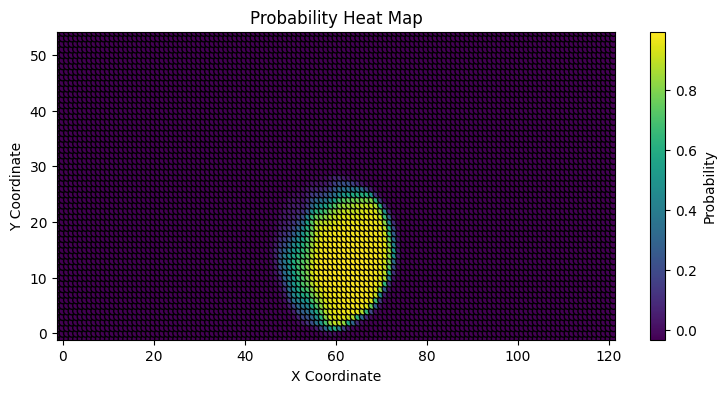

In [ ]:
# Create a regular grid to interpolate the data
xi = np.linspace(min(coords_x), max(coords_x), 200)
yi = np.linspace(min(coords_y), max(coords_y), 200)
xi, yi = np.meshgrid(xi, yi)

# Interpolate using griddata (cubic gives smoother results)
zi = griddata((coords_x, coords_y), probs, (xi, yi), method='cubic')

# Plot the heatmap
plt.figure(figsize=(9, 4))
heatmap = plt.pcolormesh(xi, yi, zi, cmap='viridis', shading='auto')
plt.scatter(coords_x, coords_y, c=probs, cmap='viridis', edgecolors='k', s=30)
plt.colorbar(heatmap, label='Probability')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Probability Heat Map')
plt.show()